## Importing required libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

In [5]:
train_data = pd.read_csv('dataset/train.csv')
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## Attributes in Dataset

* id = unique id for news articles
* title = title of the article
* author
* text = content of the article
* label 0 => not fake, 1 => fake

## Downloading Embeddings

In [6]:
import kaggle
kaggle.api.authenticate()

embeddings = kaggle.api.dataset_download_files(dataset='danielwillgeorge/glove6b100dtxt', path="./dataset", unzip=True)
print("Embedding Download Successful")

Dataset URL: https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt
Embedding Download Successful


## Preprocessing

In [7]:
# Finding null values
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [8]:
# Dropping unnecessary columns
# pd.set_option('display.max_colwidth', 1)
train_data.drop(['id', 'title', 'author'], axis=1, inplace=True)
train_data.head()

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1


In [9]:
# Dropping rows which contain null values
print(f"Dimensions of Dataset before dropping null values {train_data.shape}")
train_data.dropna(axis=0, inplace=True)
print(f"Shape after dropping null values {train_data.shape}")

Dimensions of Dataset before dropping null values (20800, 2)
Shape after dropping null values (20761, 2)


In [10]:
train_df = train_data

## Text Preprocessing

In [11]:
# Lower Casing
train_df['text'] = train_data['text'].apply(lambda x: x.lower())
train_df.head()

,text,label
0,house dem aide: we didn’t even see comey’s let...,1
1,ever get the feeling your life circles the rou...,0
2,"why the truth might get you fired october 29, ...",1
3,videos 15 civilians killed in single us airstr...,1
4,print \nan iranian woman has been sentenced to...,1


In [12]:
# Remove Punctuations
train_df['text'] = train_df['text'].str.replace('[^A-Za-z0-9\s]', '')
train_df['text'] = train_df['text'].str.replace('\n', '')
train_df['text'] = train_df['text'].str.replace('\s+', ' ')
train_df.head()

,text,label
0,house dem aide: we didn’t even see comey’s let...,1
1,ever get the feeling your life circles the rou...,0
2,"why the truth might get you fired october 29, ...",1
3,videos 15 civilians killed in single us airstr...,1
4,print an iranian woman has been sentenced to s...,1


## EDA 

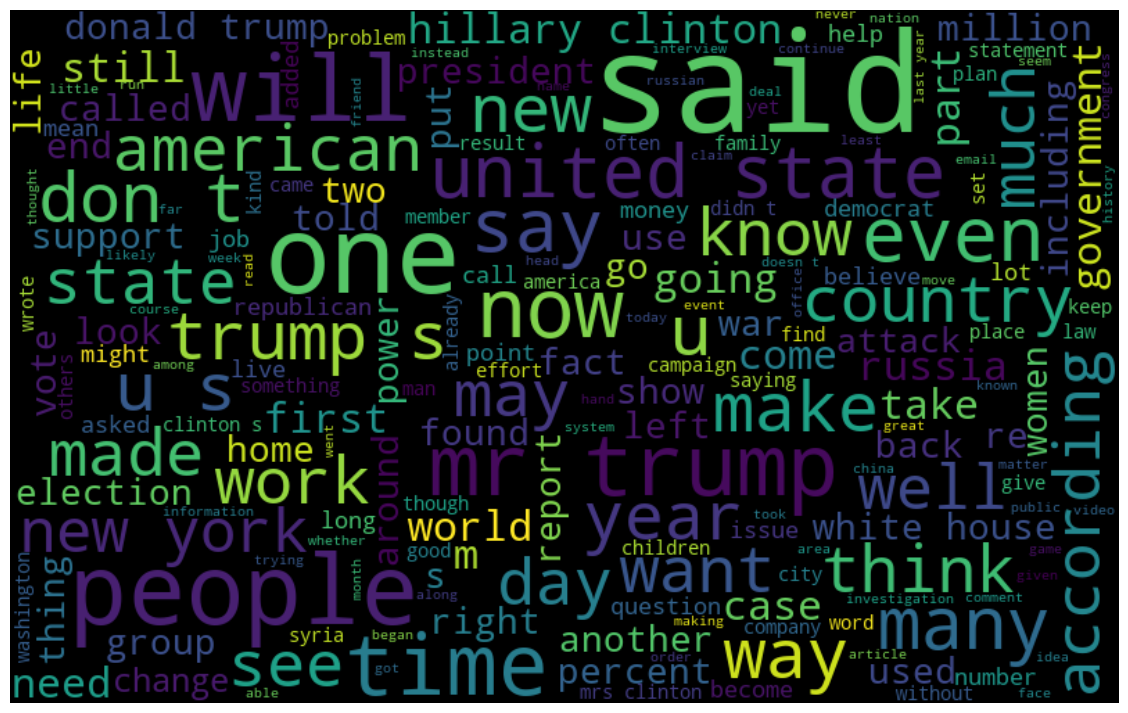

In [13]:
# visualize the frequent words
all_words = " ".join([sentence for sentence in train_df['text']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

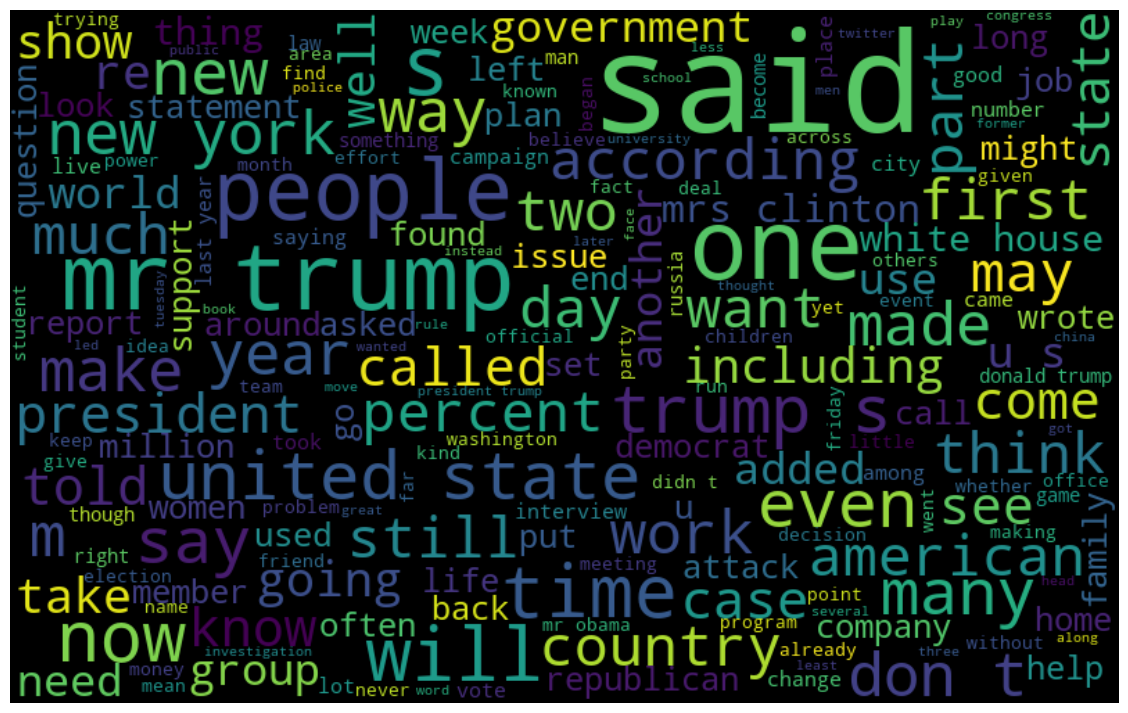

In [14]:
# visualize the frequent words for genuine news
all_words = " ".join([sentence for sentence in train_df['text'][train_df['label']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

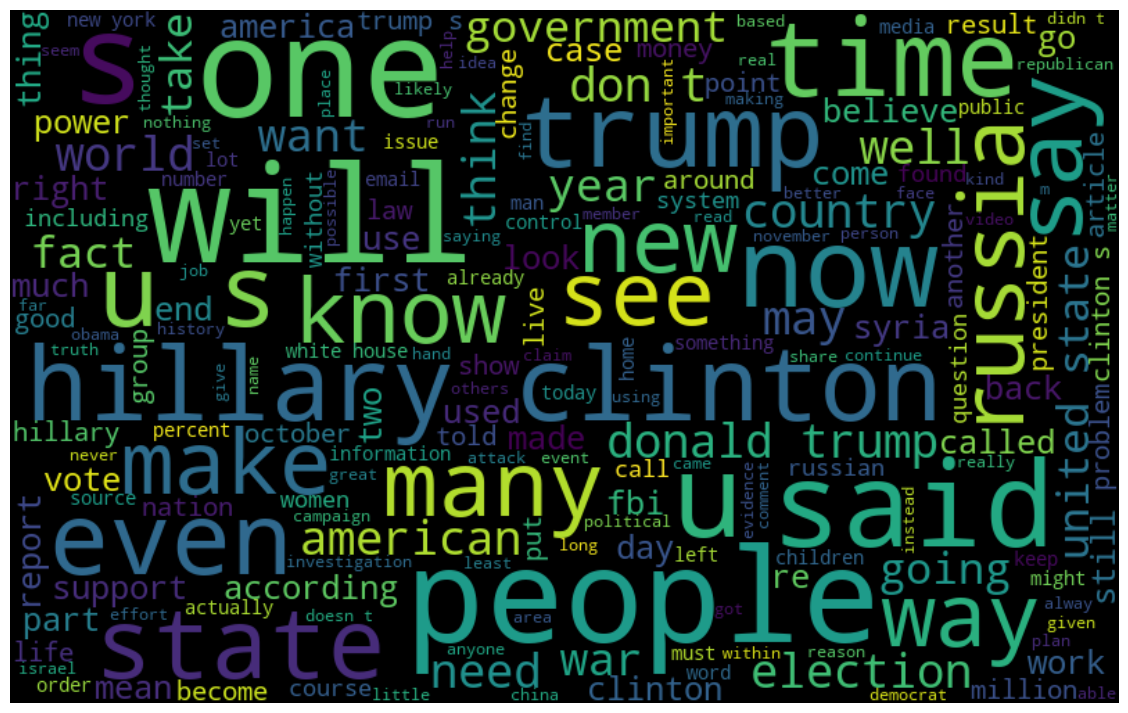

In [15]:
# visualize the frequent words for fake news
all_words = " ".join([sentence for sentence in train_df['text'][train_df['label']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Word Embedding Creation

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

239556

In [17]:
# padding data
sequences = tokenizer.texts_to_sequences(train_df['text'])
padded_seq = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

In [18]:
# create embedding index
embedding_index = {}
with open('./dataset/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [19]:
# create embedding matrix
embedding_matrix = np.zeros((vocab_size+1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [20]:
embedding_matrix[1]

array([-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
        0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
        0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
       -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
        0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
       -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
       -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
        0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
       -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
        0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
       -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
       -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
       -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
       -0.19358   , -0.074575  ,  0.23353   , -0.052062  , -0.22

In [21]:
padded_seq[1]

array([   359,    114,      1,   1739,     89,    193,   5191,      1,
        29168,    544,     67,   2463,      6,      5,   2201,    491,
          675,      1,   1724,   5627,    115,     74,    935,      1,
          291,    492,     10,   2089,      6,  18251,    945,  21175,
         3179,   2845,    782,    880,     49,     90,    370,      2,
         5460,     49,   2171,   3352,      9,      1,  11444,      3,
           49,    237,      1,    124,   2345,  92527,   3298,   3833,
            7,   3757,   3352,    942,      3,    270,   3644,    115,
        10185,  58259,     12,     72,   3423,     87,    329,     56,
           48,     94,   3399,      5,  21175,  10441,    708,      1,
           68,      3,      1,    616,   2597,     98,   2612,      6,
         8398,      7,      1,    602,    830,   1616,    758,     58,
          253,     15,     32,     82,  23502,     15,      2,     33,
           38,   1039,     13,      2,  25181,    447,      3,      1,
      

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(padded_seq, train_df['label'], test_size=0.20, random_state=42, stratify=train_df['label'])

In [23]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras import Sequential

model = Sequential([
     Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
     Dropout(0.2),
     LSTM(128, return_sequences=True),
     LSTM(128),
     Dropout(0.2),
     Dense(512),
     Dropout(0.2),
     Dense(256),
     Dense(1, activation='sigmoid')
])


In [24]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    23,955,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,955,700 (91.38 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,955,700 (91.38 MB)

In [25]:
# train the model
history = model.fit(x_train, y_train, epochs=1, batch_size=256, validation_data=(x_test, y_test))

65/65 ━━━━━━━━━━━━━━━━━━━━ 520s 8s/step - accuracy: 0.6125 - loss: 0.6602 - val_accuracy: 0.6773 - val_loss: 0.6254


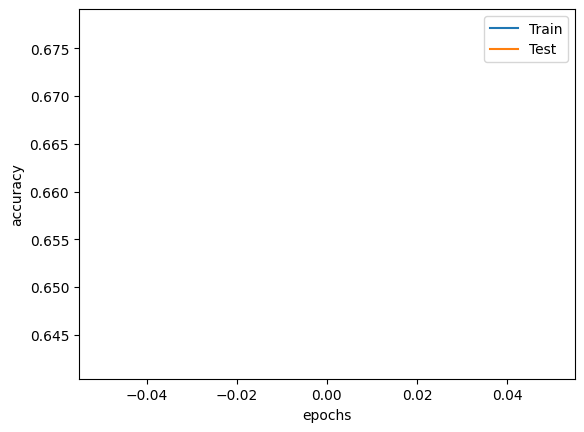

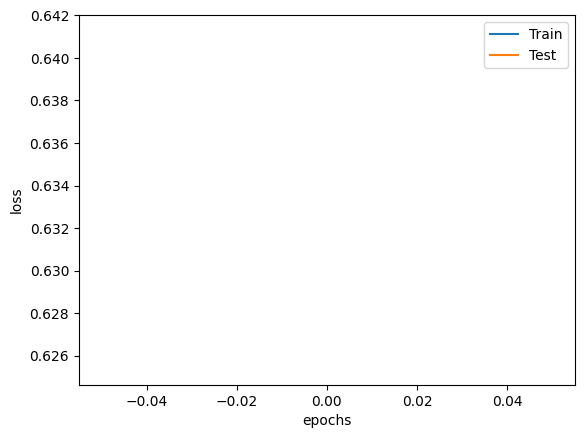

In [26]:
# visualize the results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Test'])
plt.show()

In [27]:
model.save("detection_model.keras")
model.save("detection_model.h5")

In [28]:
import pickle

with open("tokenizer.pkl", "wb") as file:
    pickle.dump(tokenizer, file)

In [29]:
user_input = input("Enter news")
tokenizer = pickle.load(open("tokenizer.pkl", "rb"))
user_sequences = tokenizer.texts_to_sequences(user_input)
user_padded = pad_sequences(user_sequences, maxlen=500)

predictions = model.predict(user_padded)
print("Predictions:", predictions)

threshold = 0.5
classification = "1" if predictions[0][0] > threshold else "0"
print("Classification:", classification)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Predictions: [[0.98442477]
 [0.98450744]
 [0.9846434 ]
 [0.98393214]
 [0.98394895]
 [0.9848178 ]
 [0.9844272 ]
 [0.98394895]
 [0.984233  ]
 [0.9848178 ]
 [0.9830762 ]
 [0.98357546]
 [0.9844272 ]
 [0.98394895]
 [0.9848178 ]
 [0.9848178 ]
 [0.98443145]
 [0.98394895]
 [0.9848178 ]
 [0.9844272 ]
 [0.98357546]
 [0.9844272 ]
 [0.98469484]
 [0.98381054]
 [0.9843718 ]
 [0.9848178 ]
 [0.98394895]
 [0.98466945]
 [0.98394895]
 [0.98469484]
 [0.9848178 ]
 [0.98393214]
 [0.98394895]
 [0.98394895]
 [0.9848178 ]
 [0.9842305 ]
 [0.98450744]
 [0.984233  ]
 [0.98394895]
 [0.9850834 ]
 [0.98381054]
 [0.98393214]
 [0.9848178 ]
 [0.98433965]
 [0.98394895]
 [0.9843718 ]
 [0.9848178 ]
 [0.9848178 ]
 [0.9848178 ]
 [0.9848178 ]]
Classification: 1


Here are the steps involved in developing the model as per the provided Jupyter Notebook:

1. **Import Required Libraries**:
    - Import necessary libraries such as `pandas`, `numpy`, `matplotlib`, `seaborn`, `tensorflow`, etc.

2. **Load Dataset**:
    - Load the dataset using `pd.read_csv()` and display the first few rows using `.head()`.

3. **Understand Dataset Attributes**:
    - Analyze the dataset attributes and understand the columns and their significance.

4. **Download Pre-trained Embeddings**:
    - Download pre-trained GloVe embeddings using the Kaggle API.

5. **Preprocessing**:
    - Check for null values using `.info()`.
    - Drop unnecessary columns like `id`, `title`, and `author`.
    - Remove rows with null values.

6. **Text Preprocessing**:
    - Convert text to lowercase.
    - Remove punctuations, special characters, and extra spaces.

7. **Exploratory Data Analysis (EDA)**:
    - Generate word clouds to visualize frequent words in the dataset, both for genuine and fake news.

8. **Tokenization and Padding**:
    - Tokenize the text using `Tokenizer` from TensorFlow.
    - Convert text to sequences and pad them to ensure uniform length.

9. **Create Embedding Matrix**:
    - Load GloVe embeddings and create an embedding index.
    - Map the embeddings to the vocabulary and create an embedding matrix.

10. **Split Dataset**:
     - Split the dataset into training and testing sets using `train_test_split()`.

11. **Build the Model**:
     - Use TensorFlow's `Sequential` API to define the model architecture:
        - Add an `Embedding` layer initialized with the embedding matrix.
        - Add `LSTM` layers for sequence modeling.
        - Add `Dropout` layers for regularization.
        - Add `Dense` layers for classification.

12. **Compile the Model**:
     - Compile the model with `binary_crossentropy` loss, `adam` optimizer, and `accuracy` as the evaluation metric.

13. **Train the Model**:
     - Train the model using `.fit()` with training and validation data.

14. **Visualize Training Results**:
     - Plot training and validation accuracy and loss over epochs.

15. **Save the Model**:
     - Save the trained model in `.keras` and `.h5` formats.
     - Save the tokenizer using `pickle`.

16. **Make Predictions**:
     - Load the tokenizer and model.
     - Preprocess user input and make predictions using the trained model.

These steps provide a complete pipeline for developing a text classification model for fake news detection.